In [1]:
# 필요 라이브러리 import
import os, sys
import urllib.request
import random
import time
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from tqdm import tqdm

In [2]:
# 데이터 경로 및 SEED 설정
DATA_DIR = "dataset"
SEED = 0xC0FFEE     # 12648430

# 재현성을 위한 시드 고정
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터 로드

In [3]:
# 이미지 형태 확인
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root="dataset/trainset", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
x, y = next(iter(loader))
print(x.shape, y.shape)

torch.Size([128, 3, 150, 150]) torch.Size([128])


> 이미지 하나만 출력해서 형태를 살펴보면 흑백임에도 채널이 3개로 되어있다.
> - 일반적인 pre-trained 모델의 input도 3채널이기 때문에 별도의 처리는 하지 않겠다.

In [5]:
# 이미지 전처리 정의
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),                # 224x224로 리사이즈
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    ])

# ImageFolder를 사용하여 데이터셋 만들기
original_dataset = datasets.ImageFolder(root="dataset/trainset")

# train/validation 분리
train_size = len(original_dataset) - 200
val_size = 200
train_dataset, val_dataset = random_split(original_dataset, [train_size, val_size])

# transform 적용
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [7]:
# 데이터 형태 확인
x, y = next(iter(train_loader))
print(x.shape, y.shape)

x, y = next(iter(validation_loader))
print(x.shape, y.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([1, 3, 224, 224]) torch.Size([1])


# Label 확인

In [6]:
classes = dataset.classes
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

print(original_dataset.class_to_idx)

{'aphids': 0, 'armyworm': 1, 'blisterbeetle': 2, 'cicadellidae': 3, 'cornborer': 4, 'cricket': 5, 'delicatula': 6, 'limacodidae': 7, 'miridae': 8, 'viridis': 9}


In [9]:
len(classes)

10

# 시각화

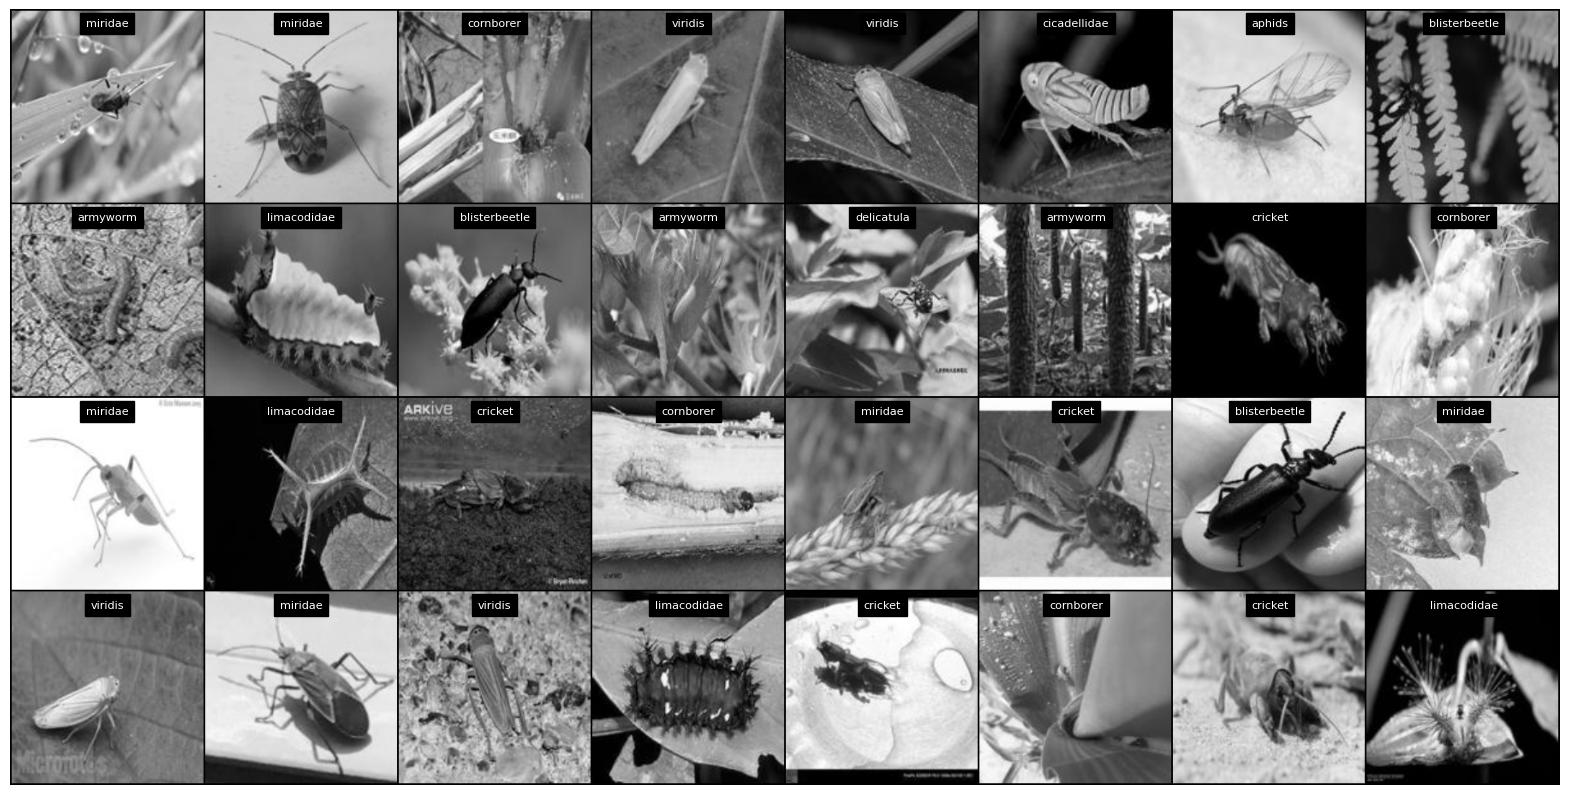

In [10]:
# 한 배치(32개)의 이미지 시각화 함수
def imshow(img, labels, classes):
    img = img.numpy().transpose((1, 2, 0))      # (C, H, W) -> (H, W, C)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    for i, label in enumerate(labels):
        x = (i % 8) * (img.shape[1] / 8) + (img.shape[1] / 16)      # 이미지의 x 좌표
        y = (i // 8) * (img.shape[0] / 4) + 10                      # 이미지의 y 좌표
        plt.text(       # 이미지 위에 라벨 표시
            x, y, classes[label], ha='center', va='top',
            color='white', fontsize=8, backgroundcolor='black'
        )
    plt.show()

# Data loader로부터 하나의 배치를 가져옴
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 그리드 만들기
img_grid = torchvision.utils.make_grid(images, nrow=8)      # 8개의 이미지를 한 줄로 나란히 이어붙임

# 이미지와 Label 시각화
imshow(img_grid, labels, classes)

# 모델 정의

In [7]:
# CUDA 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# 각종 모델 정의
class MLPModel(nn.Module):
    def __init__(self, num_classes):
        super(MLPModel, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(3 * 150 * 150, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        self.sequential = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),   # 150x150
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 75x75
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 38x38
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 19x19
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 9x9
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 4x4
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.sequential(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:
model = MLPModel(num_classes=len(classes)).to(device)
#model = CNNModel(num_classes=len(classes)).to(device)

In [12]:
# 모델 확인
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]     154,141,696
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 256]         262,400
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 64]          16,448
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
Total params: 154,421,194
Trainable params: 154,421,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.02
Params size (MB): 589.07
Estimated Total Size (MB): 589.66
----------------------------------------------------------------


In [15]:
# 손실 함수와 최적화 함수 정의
optimizer = optim.Adam(model.parameters(), lr=5e-5)     # 5e-6 = 0.000005
loss_fn = nn.CrossEntropyLoss()     # 다중 클래스 분류 문제이므로 CrossEntropyLoss 사용

# 모델 훈련 및 검증

In [16]:
# 학습 함수 정의
def fit(model, data_loader, loss_fn, optimizer, device, phase='train'):
    # phase에 따라 모델의 모드 설정
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0

    # tqdm을 사용하여 반복문 진행 상황 시각화
    prograss_bar = tqdm(data_loader, leave=False)

    # mini-batch 단위 학습 시작
    for img, lbl in prograss_bar:
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()       # 누적 Gradient 초기화

        # Gradient 계산을 통한 Forward Propagation
        with torch.set_grad_enabled(phase == 'train'):
            pred = model(img)           # Forward Propagation 수행
            loss = loss_fn(pred, lbl)   # 손실 값 계산

            if phase == 'train':        # 학습 모드인 경우 Backward Propagation 및 가중치 업데이트 수행
                loss.backward()
                optimizer.step()

        pred = pred.argmax(1)           # pred의 확률값을 클래스 레이블로 변환
        running_loss += loss.item()     # 손실 값 누적
        running_corrects += torch.sum(pred == lbl.data)    # 정답 수 누적

    # 손실 값과 정확도 계산
    final_acc = running_corrects / len(data_loader.dataset)
    final_loss = running_loss / len(data_loader.dataset)

    return final_loss, final_acc

In [17]:
# Epoch별 모델 학습
num_epochs = 20

min_loss = np.inf
max_acc = 0.0

record_train_loss, record_train_acc = [], []
record_valid_loss, record_valid_acc = [], []

STATE_DICT_PATH = "temp_model.pth"

for epoch in range(num_epochs):
    start = time.time()

    # 학습 및 검증 단계 진행
    train_loss, train_acc = fit(
        model, train_loader, loss_fn, optimizer, device, phase='train'
    )
    valid_loss, valid_acc = fit(
        model, validation_loader, loss_fn, optimizer, device, phase='valid'
    )

    # 학습 결과 기록
    record_train_loss.append(train_loss)
    record_train_acc.append(train_acc)
    record_valid_loss.append(valid_loss)
    record_valid_acc.append(valid_acc)

    # 성능이 좋아질 경우 모델 저장
    if valid_loss < min_loss:
        print(
            f"[INFO] val_loss has been improved from {min_loss:.5f} to {valid_loss:.5f}. Saving Model!"
        )
        min_loss = valid_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)

    # 학습 시간 및 손실 값, 정확도 출력
    time_elapsed = time.time() - start
    print(
        f"[Epoch{epoch+1:02d}] time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s \t loss: {train_loss:.5f}, acc: {train_acc:.5f} | val_loss: {valid_loss:.5f}, val_acc: {valid_acc:.5f}"
    )

[INFO] val_loss has been improved from inf to 2.24042. Saving Model!
[Epoch01] time: 1m 35s 	 loss: 0.06926, acc: 0.17794 | val_loss: 2.24042, val_acc: 0.20000


KeyboardInterrupt: 

# 검증 정확도 확인

> 저장한 모델의 가중치 load

In [18]:
model.load_state_dict(torch.load("temp_model.pth"))    # 가장 성능이 좋았던 모델 불러오기

<All keys matched successfully>

In [19]:
predictons = []
model = model.to(device)
model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_corrects = 0

    for img, lbl in validation_loader:
        img, lbl = img.to(device), lbl.to(device)

        pred = model(img)
        loss = loss_fn(pred, lbl)

        running_loss += loss.item()
        running_corrects += torch.sum(pred.argmax(1) == lbl.data)

        predictons.extend(pred.argmax(1).cpu().numpy())     # extend: 리스트에 다른 리스트의 요소를 추가할 때 사용

    # 손실 값과 정확도 계산
    final_acc = running_corrects / len(validation_loader.dataset)
    final_loss = running_loss / len(validation_loader.dataset)

In [20]:
# 결과 확인
print(f"<<Final Performances>>  Loss: {final_loss:.5f} | Accuracy: {final_acc:.5f}")
print(f"Prediction Length: {len(predictons)}  |  Prediction Example: {predictons[:15]}")

<<Final Performances>>  Loss: 2.24042 | Accuracy: 0.20000
Prediction Length: 200  |  Prediction Example: [0, 5, 9, 7, 8, 7, 5, 9, 0, 5, 4, 5, 9, 5, 5]


# 최종 예측 수행

In [25]:
problem = pd.read_csv(os.path.join(DATA_DIR, "problem.csv"))
problem.head()

,FilePath
0,./dataset/problemset/001.jpg
1,./dataset/problemset/002.jpg
2,./dataset/problemset/003.jpg
3,./dataset/problemset/004.jpg
4,./dataset/problemset/005.jpg


In [60]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # 'FilePath' 열에서 이미지 경로 가져오기
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image


# 이미지를 불러올 때 적용할 전처리 정의: resize, to tensor
problem_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((150, 150)),  # 이미지 크기를 (28, 28)로 조정
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    ]
)

# 커스텀 데이터셋 인스턴스 생성
custom_dataset = CustomImageDataset(dataframe=problem, transform=problem_transform)

# DataLoader 인스턴스 생성
problem_loader = DataLoader(custom_dataset, batch_size=1, shuffle=False)

In [61]:
x= next(iter(problem_loader))
print(x.shape)

torch.Size([1, 3, 224, 224])


In [63]:
predictions = []

# 검증모드 진입
model.eval()

with torch.no_grad():
    # loss 초기화
    running_loss = 0
    # 정확도 계산
    running_acc = 0
    for img in problem_loader:
        img = img.to(device)

        y_hat = model(img)
        label = y_hat.argmax(dim=1).detach().item()
        predictions.append(label)

# 숫자 라벨을 클래스 이름으로 변환
your_answer = [idx_to_class[l] for l in predictions]

In [64]:
submission = pd.read_csv(os.path.join(DATA_DIR, "submission.csv"))
submission["Label"] = your_answer

In [65]:
submission

,FilePath,Label
0,./dataset/problemset/001.jpg,cricket
1,./dataset/problemset/002.jpg,cricket
2,./dataset/problemset/003.jpg,viridis
3,./dataset/problemset/004.jpg,cornborer
4,./dataset/problemset/005.jpg,aphids
...,...,...
195,./dataset/problemset/196.jpg,viridis
196,./dataset/problemset/197.jpg,viridis
197,./dataset/problemset/198.jpg,viridis
198,./dataset/problemset/199.jpg,viridis


In [66]:
# 제출 파일 저장
submission.to_csv("MLP_baseline.csv", index=False)